# EDA and Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
%matplotlib inline

## Data Import

In [2]:
ames = pd.read_csv('../data/train.csv', index_col='Id')

The `train.csv` file is read in and assigned to an appropriately named panda dataframe. 

In [3]:
ames.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
ames.shape

(2051, 80)

In [5]:
ames.columns

Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish'

In [6]:
ames.columns = [column.lower().replace(' ', '_') for column in ames.columns]

Column names are lower-cased and the spaces are removed to better align with typical naming conventions.

In [7]:
ames.drop(columns=['pid', 'neighborhood'], inplace=True)

-  `pid` is used for parcel review and does not provide any signal for modeling.
-  Home sellers cannot change `neighborhood`. Including it in our model will provide no insight on ways to increase house value. 

## Null Values

In [8]:
ames[ames.columns[ames.isna().any()].tolist()].isna().sum().sort_values(ascending=False)

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_yr_blt      114
garage_cond        114
garage_qual        114
garage_finish      114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmt_cond           55
bsmt_qual           55
bsmtfin_type_1      55
mas_vnr_type        22
mas_vnr_area        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_cars          1
bsmtfin_sf_1         1
bsmtfin_sf_2         1
bsmt_unf_sf          1
garage_area          1
total_bsmt_sf        1
dtype: int64

### Columns with a lot of NAs

More than 80% of `fence`, `alley`, `misc_feature`, and `pool_qc` are null values. Even after imputing, these columns will not contribute much to our model. 

In [9]:
ames.drop(labels = ['fence', 'alley', 'misc_feature', 'pool_qc'], axis=1, inplace=True)

### Garage Features

In [10]:
ames.loc[(ames['garage_type'].isna() == False) & (ames['garage_finish'].isna() == True), 
     ['garage_finish', 'garage_type', 'garage_qual', 'garage_cond', 'garage_yr_blt', 'garage_cars', 'garage_area']]

,garage_finish,garage_type,garage_qual,garage_cond,garage_yr_blt,garage_cars,garage_area
Id,,,,,,,
2237,NaN,Detchd,NaN,NaN,NaN,NaN,NaN


In [11]:
ames.drop([2237], inplace=True)

We know this property has a garage because `garage_type` is specified. All other garage features are null, however. Given the information we know, we will not be able to impute values for these features. The best approach is to drop this row. The one null value for `garage_area` is also located here. Dropping this row will help us clean this column.

The remaining garage, categorical columns have null values in the same 113 rows. In the data dictionary, `NA` indicates no garage. These were interpreted as null when the data was imported. We're going to assume these properties do not have garages and impute `none`.

In [12]:
def fill_na(df, col_list, value='none'):
    for col in col_list:
        df[col].fillna(value, inplace=True)
    return

In [13]:
fill_na(df=ames,
        col_list=['garage_type', 'garage_finish', 'garage_cond', 'garage_qual'])

In [14]:
len(ames.loc[(ames['garage_yr_blt'].isna()) & (ames['garage_area'] == 0)])

113

In [15]:
ames.loc[(ames['garage_yr_blt'].isna()) & (ames['garage_area'] == 0), ['garage_yr_blt', 'garage_area']].head()

,garage_yr_blt,garage_area
Id,,
2243,NaN,0.0
330,NaN,0.0
2278,NaN,0.0
2235,NaN,0.0
2084,NaN,0.0


`garage_yr_blt` has 113 null values. Given that `garage_area` for these columns are `0.0`, we assume no garage is present on these properties. Because we cannt impute the values based on`year_built` for each property, we're going to drop the column.

In [16]:
ames.drop(labels=['garage_yr_blt'], axis=1, inplace=True)

### Fireplace Feature

In [17]:
len(ames.loc[(ames['fireplace_qu'].isna()) & (ames['fireplaces'] != 0)])

0

Properties with `fireplace_qu` as a null value also have `fireplaces` as 0. We will impute `none` to indicate that there is no fireplace.

In [18]:
fill_na(df=ames, 
        col_list=['fireplace_qu'])

### Basement Features

In [19]:
ames.loc[ames['bsmtfin_sf_1'].isna(), 
     ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 
      'bsmt_half_bath', 'bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1', 'bsmtfin_type_2', 'bsmt_exposure']].T

Id,1342
bsmtfin_sf_1,NaN
bsmtfin_sf_2,NaN
bsmt_unf_sf,NaN
total_bsmt_sf,NaN
bsmt_full_bath,NaN
bsmt_half_bath,NaN
bsmt_qual,NaN
bsmt_cond,NaN
bsmtfin_type_1,NaN
bsmtfin_type_2,NaN


Similar to categorical garage features, `NA` indicates no basement. These values were incorrectly interpreted as null values when imported. We will use the `fill_na` function to fill in `none`.

In [20]:
ames.loc[[1342], ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath']] = 0

In [21]:
ames.loc[ames['bsmt_full_bath'].isna(), ['bsmt_full_bath', 'bsmt_half_bath', 'total_bsmt_sf']]

,bsmt_full_bath,bsmt_half_bath,total_bsmt_sf
Id,,,
1498,NaN,NaN,0.0


`total_bsmt_sf = 0` so we can infer that this property does not have a basement. We can impute `0` for `bsmt_full_bath` and `bsmt_half_bath`.

In [22]:
ames.loc[[1498], ['bsmt_full_bath', 'bsmt_half_bath']] = 0, 0

In [23]:
ames.loc[(ames['bsmtfin_type_2'].isna() == True) & (ames['bsmtfin_type_1'].isna() == False),
        ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf']]

,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf
Id,,,,
445,1124.0,479.0,1603.0,3206.0


`bsmt_unf_sf` is greater than `bsmtfin_sf_2`, so I'm going to impute `Unf` for `bsmtfin_type_2`.

In [24]:
ames.loc[[445], 'bsmtfin_type_2'] = 'Unf'

In [25]:
ames.loc[(ames['bsmt_exposure'].isna() == True) & (ames['bsmtfin_type_1'].isna() == False),
        ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf','bsmt_exposure']]

,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_exposure
Id,,,,,
1797,0.0,0.0,725.0,725.0,NaN
67,0.0,0.0,1595.0,1595.0,NaN
2780,0.0,0.0,936.0,936.0,NaN


These 3 properties have basements, but are unfinished. Given that `bsmt_unf_sf` = `total_bsmt_sf`, we're going to impute `No` (No Exposure) for `bsmt_exposure`.

In [26]:
ames.loc[[1797, 67, 2780], 'bsmt_exposure'] = 'No'

In [27]:
len(ames.loc[(ames['bsmt_qual'].isna() == True) &
         (ames['bsmt_cond'].isna() == True) &
         (ames['bsmt_exposure'].isna() == True) &
         (ames['bsmtfin_type_1'].isna() == True) &
         (ames['bsmtfin_type_2'].isna() == True) &
         (ames['total_bsmt_sf'] == 0)])

55

The same 55 properties have null values for the remaining basement features and `total_bsmt_sf` = 0. We will impute 'none' for these missing values.

In [28]:
fill_na(df=ames, 
        col_list=['bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2'])

### Masonry Veneer Features

In [29]:
len(ames[(ames['mas_vnr_type'].isna() == True) & (ames['mas_vnr_area'].isna() == True)])

22

The same 22 properties have null values for `mas_vnr_type` and `mas_vnr_area`.

In [30]:
ames['mas_vnr_area'].value_counts().sort_values(ascending=False).head()

0.0      1215
120.0      11
176.0      10
200.0      10
72.0        9
Name: mas_vnr_area, dtype: int64

Most values in `mas_vnr_area` are zero. Given its low variance, we're going to drop these columns.

In [31]:
ames.drop(labels=['mas_vnr_area', 'mas_vnr_type'], axis=1, inplace=True)

### Lot Frontage

In [32]:
ames.loc[:, ['lot_frontage', 'lot_area']].head()

,lot_frontage,lot_area
Id,,
109,NaN,13517
544,43.0,11492
153,68.0,7922
318,73.0,9802
255,82.0,14235


In [33]:
len(ames['lot_frontage'].value_counts())

118

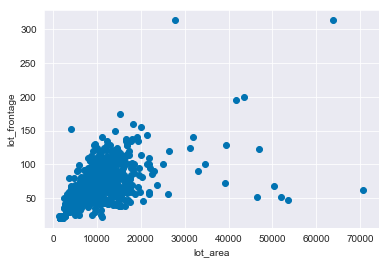

In [34]:
plt.scatter(x=ames['lot_area'],
            y=ames['lot_frontage'])

plt.xlabel('lot_area')
plt.ylabel('lot_frontage');

In [35]:
ames['lot_area'].corr(ames['lot_frontage'])

0.5740848310802272

In [36]:
ames.drop(labels=['lot_frontage'], axis=1, inplace=True)

## Visualization

### Correlation between numerical columns and target variable (`saleprice`)

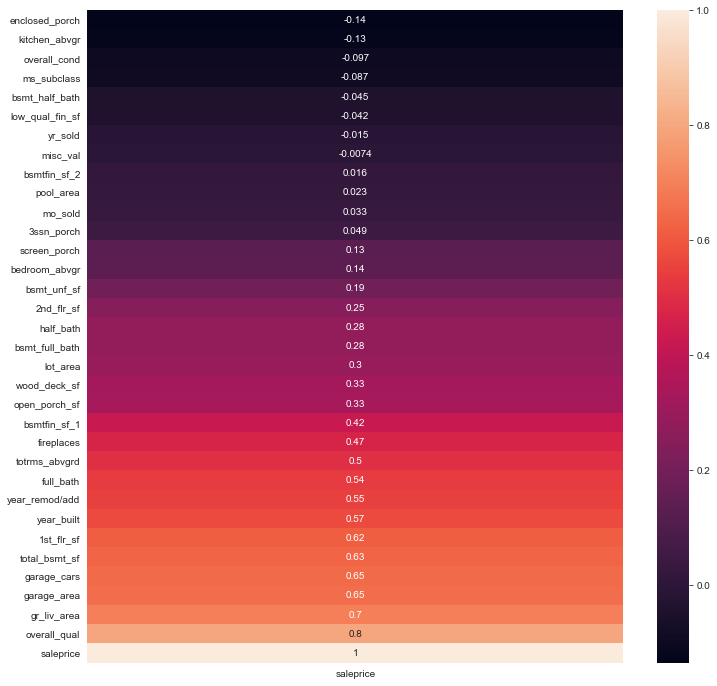

In [37]:
plt.figure(figsize=(12, 12))
sns.heatmap(ames.corr()[['saleprice']].sort_values('saleprice'), annot=True);

-  The correlation between numerical features and `saleprice` is shown here.
-  Features that involve size, such as `total_bsmt_sf`, `garage_area` and `gr_liv_area` have a high correlation with `saleprice`.
-  Features that are not required to be in a house, such as `pool_area` and `misc_val` have a low correlation with `saleprice`.

In [38]:
low_corr = []
for col in ames.select_dtypes(exclude='object').columns:
    if abs(ames['saleprice'].corr(ames[col])) < .050:
        low_corr.append(col)

In [39]:
low_corr

['bsmtfin_sf_2',
 'low_qual_fin_sf',
 'bsmt_half_bath',
 '3ssn_porch',
 'pool_area',
 'misc_val',
 'mo_sold',
 'yr_sold']

-  These features all have a correlation less than .05 with `saleprice`. 
-  We'll drop these columns.
-  We'll refrain from dropping `bsmtfin_sf_2` in order to see how it compares to `bsmtfin_sf_1`.

In [40]:
ames.drop(columns=['misc_val', 'mo_sold', 'yr_sold', 'pool_area', 'low_qual_fin_sf', '3ssn_porch'], inplace=True)

In [41]:
high_corr = []
for col in ames.select_dtypes(exclude='object').columns:
    if abs(ames['saleprice'].corr(ames[col])) > 0.15:
        high_corr.append(col)

In [42]:
high_corr

['lot_area',
 'overall_qual',
 'year_built',
 'year_remod/add',
 'bsmtfin_sf_1',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 '1st_flr_sf',
 '2nd_flr_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'full_bath',
 'half_bath',
 'totrms_abvgrd',
 'fireplaces',
 'garage_cars',
 'garage_area',
 'wood_deck_sf',
 'open_porch_sf',
 'saleprice']

-  These 19 (excluding `saleprice`) features have a correlation greater than `0.15` with `saleprice`. 
-  Exploring these features further may provide more insights.

### Scatter Plot - Numerical Features

In [43]:
def subplot_scatter(df, x_list, y):
    nrows = int(np.ceil(len(x_list)/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(20, 5*nrows))
    ax = ax.ravel()
    
    if len(x_list) % 2 !=0:
        ax[len(x_list)].set_visible(False)
    
    for i, x in enumerate(x_list):
        ax[i].scatter(df[x], df[y])
        ax[i].set_title(f'{y} vs {x}', fontsize=20)
        ax[i].set_ylabel(f'{y}', fontsize=15)
        ax[i].set_xlabel(f'{x}', fontsize=15)
    
    plt.tight_layout()

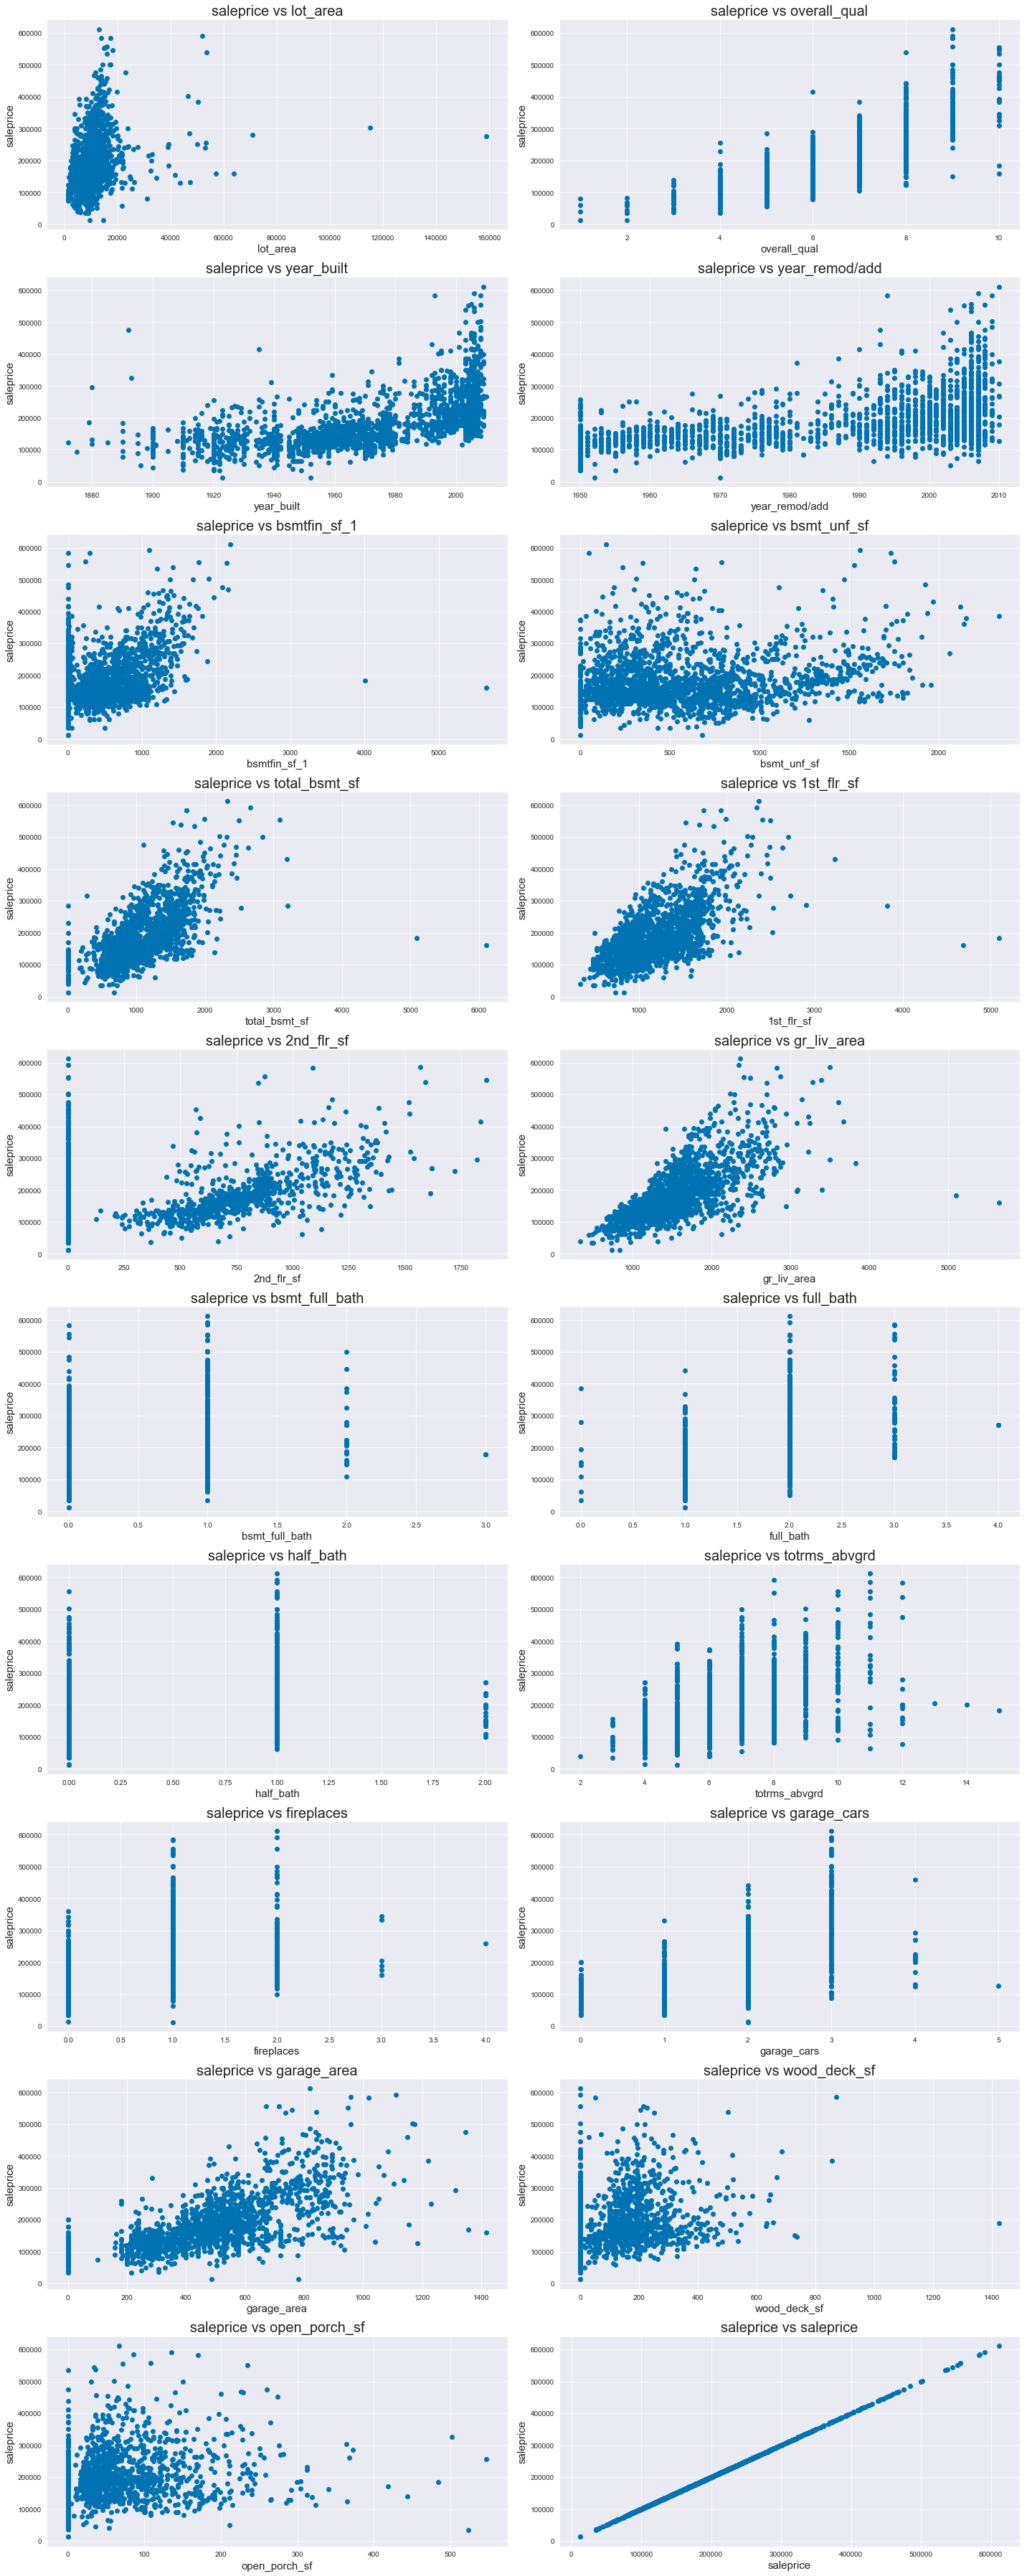

In [44]:
subplot_scatter(df=ames,
                x_list=high_corr,
                y='saleprice')

-  Most of the features have a positive relationship with `saleprice`.
-  Features like `bsmt_full_bath` and `overall_qual` are discrete, so we see the data points moving upward as `saleprice` increases rather than up and outward. 
-  We see the same trends as our heatmap, where `overall_qual` and `gr_liv_area` have a strong, positive linear relationshi with `saleprice`.

#### Outliers

There are outliers for features with a high correlation that should be removed to prevent them from skewing our model: 
-  `bsmtfin_sf_2`
-  `gr_liv_area`
-  `total_bsmt_sf`

In [45]:
ames.loc[ames['bsmtfin_sf_2'] > 1300, ['bsmtfin_sf_2', 'lot_area']]

,bsmtfin_sf_2,lot_area
Id,,
2093,1474.0,10380
2451,1393.0,17242


In [46]:
ames.drop(labels=[2093, 2451], inplace=True)

In [47]:
ames.loc[ames['gr_liv_area'] > 5000, ['bsmtfin_sf_1', 'total_bsmt_sf']]

,bsmtfin_sf_1,total_bsmt_sf
Id,,
1499,5644.0,6110.0
2181,4010.0,5095.0


In [48]:
ames.drop(labels=[1499, 2181], inplace=True)

In [49]:
ames.loc[ames['lot_area'] > 100000, ['lot_area', 'gr_liv_area']]

,lot_area,gr_liv_area
Id,,
2116,159000,2144
2072,115149,1824


In [50]:
ames.drop(labels=[2116, 2072], inplace=True)

### Boxplot - Categorical Features

In [51]:
def subplot_boxplot(df, x_list, y):
    nrows = int(np.ceil(len(x_list)/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(20, 5*nrows))
    ax = ax.ravel()
    
    if len(x_list) % 2 !=0:
        ax[len(x_list)].set_visible(False)
    
    for i, x in enumerate(x_list):
        sns.boxplot(df[x], df[y], ax=ax[i], color='lightblue')
        ax[i].set_title(f'Boxplot of {x} and {y}', fontsize=20)
        ax[i].set_ylabel(f'{y}', fontsize=15)
        ax[i].set_xlabel(f'{x}', fontsize=15)
    
    plt.tight_layout()

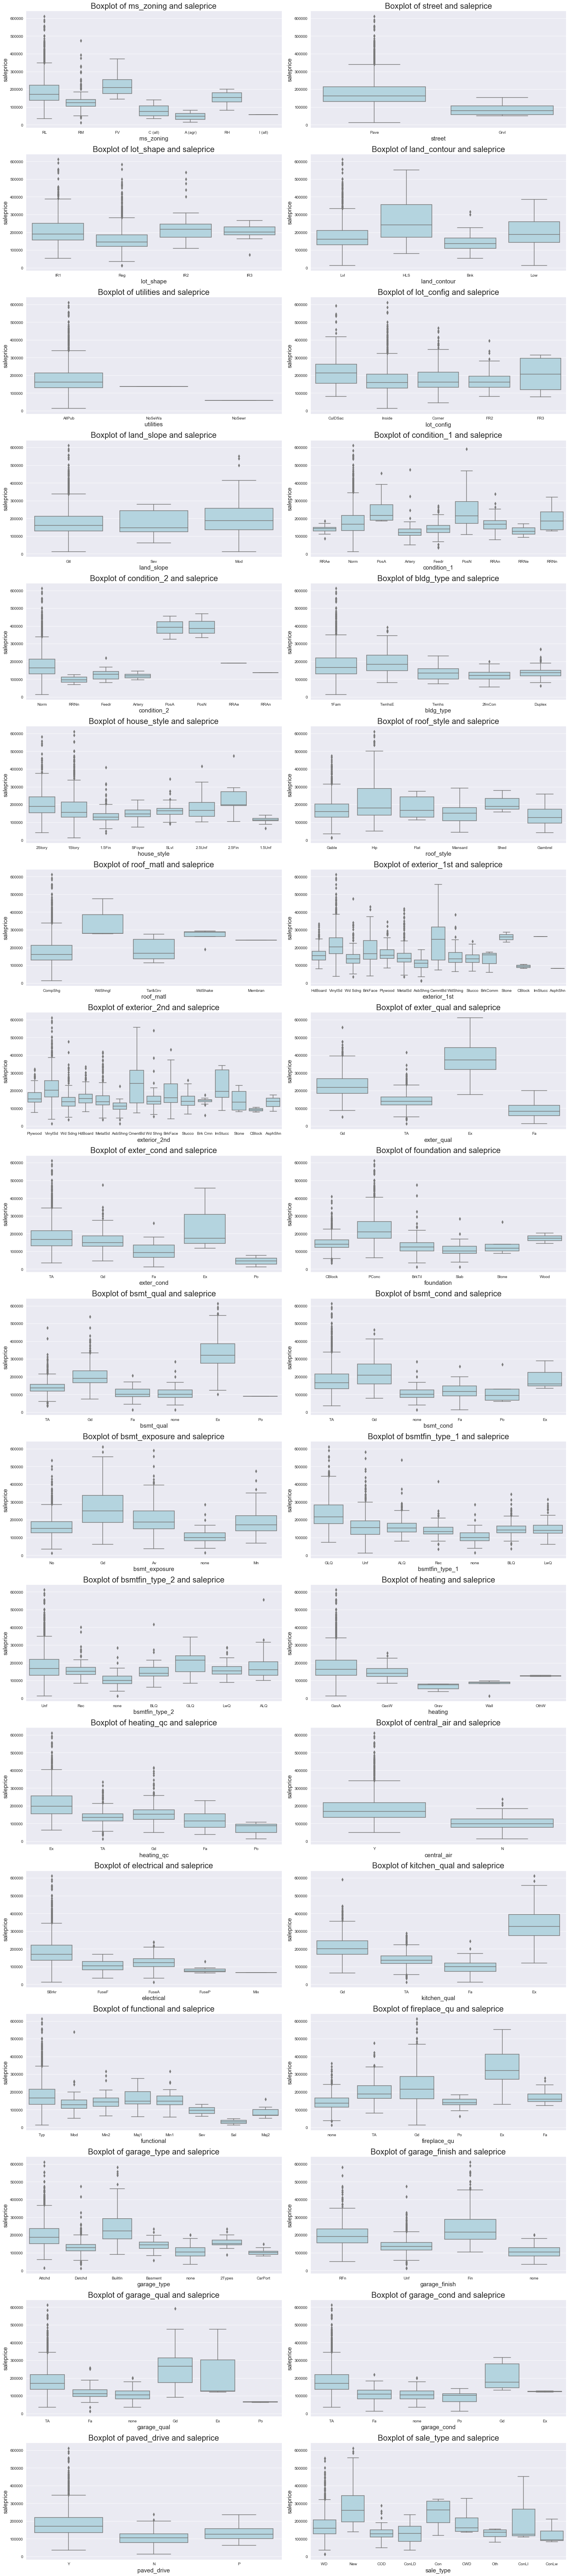

In [52]:
subplot_boxplot(df=ames,
                x_list=ames.select_dtypes(include='object').columns,
                y='saleprice')

-  `utilities` has a low variance, given its small interquartile range. Since two of three categories display this, we will drop this column.
-  The median for `exterior_1st` and `exterior_2nd` varies drastically across categories.
-  We can see the most difference amongst categories for `ms_zoning`. The median and interquartile range are different for each.
-  For `condition_2`, being close or adjacent to an off-site feature (ex. park) leads to a greater `saleprice`.

In [53]:
ames.drop(columns=['utilities'], inplace=True)

## Save as CSV

In [54]:
ames.to_csv('../data/train_clean.csv')